In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mplleaflet

from math import sin, cos, sqrt, atan2, radians,ceil

In [101]:
from numba import vectorize,jit,njit

In [102]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [103]:
df = pd.read_csv(r'C:\Users\Seba\DWC project\DataWorkshop.csv')

In [104]:
df.head()

,Data zdarzenia,Godzina,GPS x,GPS y,Miejscowość,Ulica,Numer domu,Numer drogi,KM HM (Pikietaż),Obszar,...,Sygnalizacja świetlna,Oznakowanie poziome,Liczba pasów w zdarzeniu,Zachowanie kierującego,Zachowanie pieszego,Inne przyczyny,Liczba rannych w zdarzeniu,Liczba zabitych w zdarzeniu,Liczba kolizji,Liczba wypadków
0,2016-01-01,05:15:00,18*38'089,50*22'110,GLIWICE,TOSZECKA,NaN,901,"61,6",Obszar niezabudowany,...,Brak,Jest,2.0,NaN,NaN,"Obiekty, zwierzęta na drodze",0,0,1,0
1,2016-01-01,00:05:00,19*10'510,50*19'231,DĄBROWA GÓRNICZA,SIENKIEWICZA,NaN,G200 030S,NaN,Obszar zabudowany,...,Brak,Jest,NaN,Nieprawidłowe: cofanie,NaN,NaN,0,0,1,0
2,2016-01-01,18:30:00,18*52'395,50*26'423,TARNOWSKIE GÓRY,KS.IGNACEGO SIWCA,4A,GMINNA,NaN,Obszar zabudowany,...,Brak,Nie ma,2.0,Nieprawidłowe: omijanie,NaN,NaN,0,0,1,0
3,2016-01-01,15:10:00,18*51'381,50*26'408,TARNOWSKIE GÓRY,JÓZEFA PIŁSUDSKIEGO,6,P3276S,NaN,Obszar zabudowany,...,Brak,Jest,2.0,Nieprawidłowe: omijanie,NaN,NaN,0,0,1,0
4,2016-01-01,17:45:00,19*02'512,50*28'005,OŻAROWICE,DWORCOWA,16,P3203S,NaN,Obszar zabudowany,...,Brak,Nie ma,2.0,NaN,NaN,"Obiekty, zwierzęta na drodze",0,0,1,0


In [105]:
df2 = df.copy()

In [83]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229929 entries, 0 to 229928
Data columns (total 30 columns):
Data zdarzenia                       229929 non-null object
Godzina                              229929 non-null object
GPS x                                229929 non-null object
GPS y                                229929 non-null object
Miejscowość                          229929 non-null object
Ulica                                209201 non-null object
Numer domu                           136045 non-null object
Numer drogi                          229929 non-null object
KM HM (Pikietaż)                     35041 non-null object
Obszar                               229928 non-null object
Skrzyżowanie                         63150 non-null object
Geometria drogi                      163921 non-null object
Charakterystyka miejsca zdarzenia    229927 non-null object
Oświetlenie                          229929 non-null object
Warunki atmosferyczne                229928 non-nul

In [84]:
print('Liczba unikalnych dat:', df2['Data zdarzenia'].nunique())
print('Pierwsza data', df2['Data zdarzenia'].min())
print('Ostatnia data', df2['Data zdarzenia'].max())

Liczba unikalnych dat: 1461
Pierwsza data 2016-01-01
Ostatnia data 2019-12-31


In [106]:
#Wyciągnięcie roku,miesiąca,dnia,godziny,dzień tygodnia,weekend
df2['Data zdarzenia'] = pd.to_datetime(df2['Data zdarzenia'], errors='coerce')
df2['Godzina'] = pd.to_datetime(df2['Godzina'], errors='coerce')
df2['rok'] = df2['Data zdarzenia'].dt.year
df2['miesiąc'] = df2['Data zdarzenia'].dt.month
df2['dzień'] = df2['Data zdarzenia'].dt.day
df2['godzina'] = df2['Godzina'].dt.hour
df2['dzień_tygodnia'] = df2['Data zdarzenia'].dt.dayofweek
df2['weekend'] = df2['dzień_tygodnia'].map(lambda x: 1 if x in [5,6] else 0)

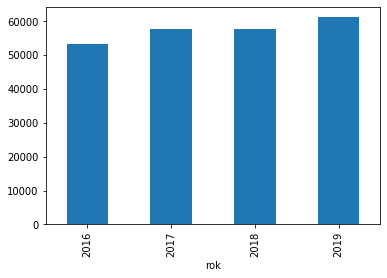

In [107]:
df2.groupby('rok')['Data zdarzenia'].count().plot(kind='bar') 

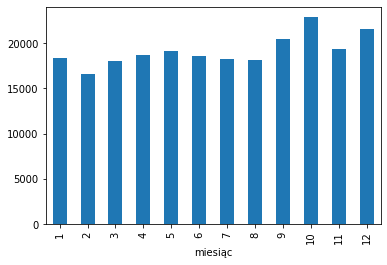

In [108]:
df2.groupby('miesiąc')['Data zdarzenia'].count().plot(kind='bar') 

In [109]:
df2['Miejscowość'].nunique()

1097

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

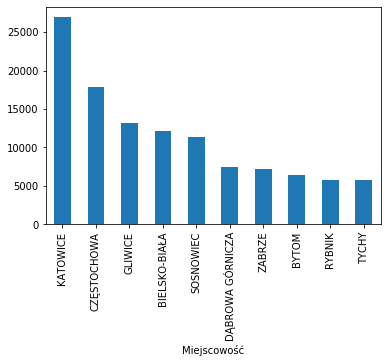

In [110]:
df2.groupby('Miejscowość')['Godzina'].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.xticks(rotation='vertical')

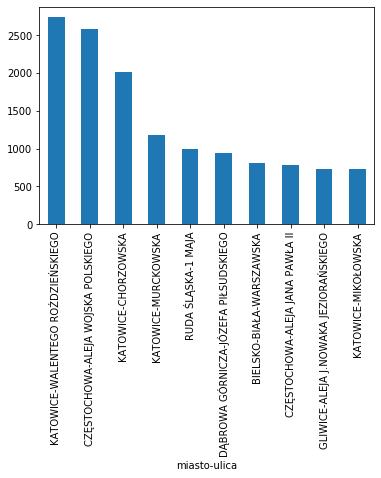

In [111]:
df2['miasto-ulica'] = df['Miejscowość'] +'-'+ df['Ulica']
df2.groupby('miasto-ulica')['Godzina'].count().sort_values(ascending=False).head(10).plot(kind='bar')

In [112]:
df2.columns

Index(['Data zdarzenia', 'Godzina', 'GPS x', 'GPS y', 'Miejscowość', 'Ulica',
       'Numer domu', 'Numer drogi', 'KM HM (Pikietaż)', 'Obszar',
       'Skrzyżowanie', 'Geometria drogi', 'Charakterystyka miejsca zdarzenia',
       'Oświetlenie', 'Warunki atmosferyczne', 'Rodzaj zdarzenia', 'Wina',
       'Rodzaj drogi', 'Nawierzchnia drogi', 'Stan nawierzchni',
       'Sygnalizacja świetlna', 'Oznakowanie poziome',
       'Liczba pasów w zdarzeniu', 'Zachowanie kierującego',
       'Zachowanie pieszego', 'Inne przyczyny', 'Liczba rannych w zdarzeniu',
       'Liczba zabitych w zdarzeniu', 'Liczba kolizji', 'Liczba wypadków',
       'rok', 'miesiąc', 'dzień', 'godzina', 'dzień_tygodnia', 'weekend',
       'miasto-ulica'],
      dtype='object')

In [113]:
black_list = ['Data zdarzenia','Godzina','GPS x','GPS y',]
for column in [x for x in df2.columns if x not in black_list]:
    print(column)
    print('')
    print(df2[column].value_counts(normalize=True).head(10))
    print('')

Miejscowość

KATOWICE            0.117045
CZĘSTOCHOWA         0.077554
GLIWICE             0.057200
BIELSKO-BIAŁA       0.052929
SOSNOWIEC           0.049220
DĄBROWA GÓRNICZA    0.032523
ZABRZE              0.031392
BYTOM               0.028126
RYBNIK              0.025221
TYCHY               0.025047
Name: Miejscowość, dtype: float64

Ulica

KATOWICKA                   0.019670
JÓZEFA PIŁSUDSKIEGO         0.015191
WALENTEGO ROŹDZIEŃSKIEGO    0.013771
CHORZOWSKA                  0.012954
ALEJA WOJSKA POLSKIEGO      0.012586
1 MAJA                      0.012036
PSZCZYŃSKA                  0.011439
3 MAJA                      0.011415
GLIWICKA                    0.011152
WARSZAWSKA                  0.010999
Name: Ulica, dtype: float64

Numer domu

1           0.055077
2           0.041369
NIEZNANE    0.029681
3           0.025668
5           0.024808
4           0.023544
6           0.021699
10          0.020640
7           0.019008
8           0.017663
Name: Numer domu, dtype: float64



In [134]:
def simplify(a):        
    a = a.replace('\'','')                   # usuń znaki '
    a = a.replace('\n','')                   # usuń znaki nowej linii
    a = a.replace(';','')                    # usuń średniki
    a = a.replace(',','')                    # usuń przecinki
    a = a.replace('.',' ')                   # zamień kropki na spacje (ze względu na dziwny zapis w adresach)
    a = a.replace('  ',' ')                  # usuń podwójne spacje
    a = a.replace('(od 11 2015)','')         # usuń ciąg "(od 11.2015)"
    a = a.lower()                            # zamień wielkie litery na małe
    a=' '.join(unique_list(a.split()))       # usuń zduplikowane słowa
    return(a)

def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist 

def simplify_column(serie):
    a = serie.unique()                       # wrzuć wartości do tablicy numpy
    a = np.array2string(a)                   # przekształć tablicę na string
    return(simplify(a))

def simplify_cell(string):
    return(simplify(str(string)))

In [119]:
df2.columns

Index(['Data zdarzenia', 'Godzina', 'GPS x', 'GPS y', 'Miejscowość', 'Ulica',
       'Numer domu', 'Numer drogi', 'KM HM (Pikietaż)', 'Obszar',
       'Skrzyżowanie', 'Geometria drogi', 'Charakterystyka miejsca zdarzenia',
       'Oświetlenie', 'Warunki atmosferyczne', 'Rodzaj zdarzenia', 'Wina',
       'Rodzaj drogi', 'Nawierzchnia drogi', 'Stan nawierzchni',
       'Sygnalizacja świetlna', 'Oznakowanie poziome',
       'Liczba pasów w zdarzeniu', 'Zachowanie kierującego',
       'Zachowanie pieszego', 'Inne przyczyny', 'Liczba rannych w zdarzeniu',
       'Liczba zabitych w zdarzeniu', 'Liczba kolizji', 'Liczba wypadków',
       'rok', 'miesiąc', 'dzień', 'godzina', 'dzień_tygodnia', 'weekend',
       'miasto-ulica'],
      dtype='object')

In [141]:
def feature_engineering(df):
    df = df.fillna(-1)
    df.drop('Godzina',axis=1,inplace=True)
    df.drop('Numer domu',axis=1,inplace=True)
    
    #Po próbie zamiany na float wyskakuje błąd w dwóch wierszach z uwagi na błędy lub braki, trzeba to poprawić
    df['GPS x'][31931] = "18*28'05"
    df['GPS x'][107220] = "18*39'0"
    df['GPS x'][31931] = "18*28'05"
    df['GPS y'][142857] = "50*09'01"
    df['GPS y'][149393] = "50*18'11"
    df['GPS y'][161201] = "50*25'27"
    df.drop(135253,inplace=True)
    
    #Zamiana na szerokośc i długość gograficzną
    #DD = degrees + (min/60) + (sec/3600)
    df['LON'] = df['GPS x'].map(lambda x: int(str(x).replace('*',' ').replace("'",' ').split(' ')[0]) 
                            +float(str(x).replace('*',' ').replace("'",' ').split(' ')[1])/60 
                            +float(str(x).replace('*',' ').replace("'",' ').split(' ')[2])/36000)
    
    df2['LAT'] = df['GPS y'].map(lambda x: int(str(x).replace('*',' ').replace("'",' ').split(' ')[0]) 
                            +float(str(x).replace('*',' ').replace("'",' ').split(' ')[1])/60 
                            +float(str(x).replace('*',' ').replace("'",' ').split(' ')[2])/36000)
    
    
    
    df['miasto-ulica'] = str(df['Miejscowość']) +'-'+ str(df['Ulica'])
    df['miasto-ulica'] = df['miasto-ulica'].apply(lambda x: simplify(x) )
    df.drop('Ulica',axis=1,inplace=True)
    
    df['pikietaz'] = df['KM HM (Pikietaż)'].map(lambda x: str(x).replace(',','.') if x!= -1 else -1).astype(float)
    df.drop('KM HM (Pikietaż)',axis=1,inplace=True)
    
    df['numer_drogi'] = df['Numer drogi'].factorize()[0]
    df.drop('Numer drogi',axis=1,inplace=True)
    
    df['obszar'] = df['Obszar'].factorize()[0]
    df.drop('Obszar',axis=1,inplace=True)
    
    df['skrzyzowanie'] = df['Skrzyżowanie'].apply(lambda x: simplify(str(x)))
    df['skrzyzowanie'] =df['skrzyzowanie'].factorize()[0]
    df.drop('Skrzyżowanie',axis=1,inplace=True)
    
    geometria_drogi_dict = {'Odcinek prosty' : 0,
                        'Zakręt, łuk' :1,
                        'Spadek' : 2,
                        'Wzniesienie' : 3
    }
    
    df['geometria_drogi'] = df['Geometria drogi'].apply(lambda x: simplify(str(x)))
    df['geometria_drogi'] = df['geometria_drogi'].map(geometria_drogi_dict).map(lambda x: x if x in [0,1,2,3] else -1)
    df.drop('Geometria drogi',axis=1,inplace=True)
    
    cmz_dict = {'jezdnia' : 0,
                        'parking plac' :1,
                        'pobocze' : 2,
                        'przejście dla pieszych' : 3,
                        'chodnik droga dla pieszych': 4 
    }
    
    df2['charakterystyka_miejsca_zdarzenia'] = df['Charakterystyka miejsca zdarzenia'].apply(lambda x:simplify(str(x)) )
    df2['charakterystyka_miejsca_zdarzenia'] = df2['charakterystyka_miejsca_zdarzenia'].apply(lambda x: str(x).replace('mop','').rstrip() )
    df2['charakterystyka_miejsca_zdarzenia'] = df2['charakterystyka_miejsca_zdarzenia'].apply(lambda x: str(x).replace('tramwajowe','').rstrip() )
    df['charakterystyka_miejsca_zdarzenia'] = df['charakterystyka_miejsca_zdarzenia'].map(cmz_dict).map(lambda x: x if x in [0,1,2,3,4] else -1)
    df.drop('Charakterystyka miejsca zdarzenia',axis=1,inplace=True)
    
    
    df['oswietlenie'] = df['Oświetlenie'].apply(lambda x: 'Świt, zmrok' if x == 'Zmrok, świt' else x)
    df['oswietlenie'] = df['oswietlenie'].apply(lambda x: 'dzień' if x == 'Światło dzienne' else x)
    df['oswietlenie'] = df['oswietlenie'].factorize()[0]
    df.drop('Oświetlenie',axis=1,inplace=True)
    
    df['pogoda_dobre_warunki'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'dobre' in str(x).lower() else 0)
    df['pogoda_pochmurno'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'pochmurno' in str(x).lower() else 0)
    df['pogoda_deszcz'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'opady deszczu' in str(x).lower() else 0)
    df['pogoda_snieg'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'opady śniegu' in str(x).lower() else 0)
    df['pogoda_dym'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'dym' in str(x).lower() else 0)
    df['pogoda_oslep_slonce'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'słońce' in str(x).lower() else 0)
    df['pogoda_opady'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'opady' in str(x).lower() else 0)
    df['pogoda_grad'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'gradu' in str(x).lower() else 0)
    df['pogoda_wiatr'] = df['Warunki atmosferyczne'].apply(lambda x: 1 if 'wiatr' in str(x).lower() else 0)
    df.drop('Warunki atmosferyczne',axis=1,inplace=True)
    
    df['rodzaj zdarzenia'] = df['Rodzaj zdarzenia'].factorize()[0]
    df.drop('Rodzaj zdarzenia',axis=1,inplace=True)
    
    df['wina'] = df.apply(lambda x: x['Inne przyczyny'] if (x['Wina'] == 'z innych przyczyn') else x['Wina'], axis=1)
    df['wina'] = df['wina'].apply(lambda x: simplify_cell(x))
    df['wina'] = df['wina'].factorize()[0]
    df.drop('Wina',axis=1,inplace=True)
    
    df['rodzaj drogi'] = df['Rodzaj drogi'].factorize()[0]
    df.drop('Rodzaj drogi',axis=1,inplace=True)
    
    df['nawierzchnia drogi'] = df['Nawierzchnia drogi'].factorize()[0]
    df.drop('Nawierzchnia drogi',axis=1,inplace=True)
    
    df['stan_nawierzchni'] = df['Stan nawierzchni'].apply(lambda x: simplify_cell(x))
    df['nawierzchnia_sucha']           = df['stan_nawierzchni'].apply(lambda x: 1 if 'sucha' in str(x).lower() else 0)
    df['nawierzchnia_mokra']           = df['stan_nawierzchni'].apply(lambda x: 1 if 'mokra' in str(x).lower() else 0)
    df['nawierzchnia_oblodzona']       = df['stan_nawierzchni'].apply(lambda x: 1 if ('oblodzona' in str(x).lower() or 'oblodzenie' in str(x).lower()) else 0)
    df['nawierzchnia_zasniezona']      = df['stan_nawierzchni'].apply(lambda x: 1 if ('zaśnieżona' in str(x).lower() or 'zaśnieżenie' in str(x).lower()) else 0)
    df['nawierzchnia_koleiny']         = df['stan_nawierzchni'].apply(lambda x: 1 if 'koleiny' in str(x).lower() else 0)
    df['nawierzchnia_garby']           = df['stan_nawierzchni'].apply(lambda x: 1 if 'garby' in str(x).lower() else 0)
    df['nawierzchnia_zanieczyszczona'] = df['stan_nawierzchni'].apply(lambda x: 1 if 'zanieczyszczona' in str(x).lower() else 0)
    df['nawierzchnia_dziury']          = df['stan_nawierzchni'].apply(lambda x: 1 if 'dziury' in str(x).lower() else 0)
    df['nawierzchnia_wyboje']          = df['stan_nawierzchni'].apply(lambda x: 1 if 'wyboje' in str(x).lower() else 0)
    df['nawierzchnia_kaluze']          = df['stan_nawierzchni'].apply(lambda x: 1 if 'kałuże' in str(x).lower() else 0)
    df['nawierzchnia_rozlewiska']      = df['stan_nawierzchni'].apply(lambda x: 1 if 'rozlewiska' in str(x).lower() else 0)
    df.drop('stan_nawierzchni',axis=1,inplace=True)
    df.drop('Stan nawierzchni',axis=1,inplace=True)
    
    df['Sygnalizacja świetlna'] = df['Sygnalizacja świetlna'].factorize()[0]
    df['sygnalizacja_swietlna'] = df['Sygnalizacja świetlna'].apply(lambda x: 1 if x==1 else 0)
    df.drop('Sygnalizacja świetlna',axis=1,inplace=True)
    
    df['oznakowanie poziome'] = df['Oznakowanie poziome'].factorize()[0]
    df.drop('Oznakowanie poziome',axis=1,inplace=True)
    
    df['liczba pasow'] = df['Liczba pasów w zdarzeniu'].apply(lambda x: -1 if x>8 else x)
    df.drop('Liczba pasów w zdarzeniu',axis=1,inplace=True)
    
    df['zachowanie_kierujacego'] = df['Zachowanie kierującego'].apply(lambda x: simplify_cell(x))
    df.drop('Zachowanie kierującego',axis=1,inplace=True)
    
    df['zachowanie_kierujacego_niepr_cofanie']             = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'cofanie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_omijanie']            = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'omijanie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niedost_predkosci']         = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'prędkości' in str(x).lower() else 0)
    df['zachowanie_kierujacego_nieudzielenie_pierw']       = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'pierwszeństwa' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_skrecanie']           = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'skręcanie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niezachowanie_odl']         = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'bezp. odl.' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_zmiana_pasa']         = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'zmienianie ' in str(x).lower() else 0)
    df['zachowanie_kierujacego_zmeczenie']                 = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'zmęczenie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_wymijanie']           = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'wymijanie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_nieprzestrz_znakow']        = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'nieprzestrzeganie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niestos_do_sygn']           = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'sygnalizacji' in str(x).lower() else 0)
    df['zachowanie_kierujacego_nieust_przejazdu']          = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'przejazdu' in str(x).lower() else 0)
    df['zachowanie_kierujacego_nieust_pieszemu']           = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'pieszemu' in str(x).lower() else 0)
    df['zachowanie_kierujacego_gwalt_hamowanie']           = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'gwałtowne' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_wyprzedzanie']        = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'wyprzedzanie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_zatrzymanie']         = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'zatrzymanie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_zawracanie']          = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'zawracanie' in str(x).lower() else 0)
    df['zachowanie_kierujacego_niepr_przejazd_rowerowy']   = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'rowerzystów' in str(x).lower() else 0)
    df['zachowanie_kierujacego_jazda_bez_swiatel']         = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'świateł' in str(x).lower() else 0)
    df['zachowanie_kierujacego_inne_przyczyny']            = df['zachowanie_kierujacego'].apply(lambda x: 1 if 'inne' in str(x).lower() else 0)
    
    df['zachowanie_pieszego'] = df['Zachowanie pieszego'].apply(lambda x: simplify_cell(x))
    df['zachowanie_pieszego'] = df['zachowanie_pieszego'].factorize()[0]
    
    df.drop('Inne przyczyny',axis=1,inplace=True)
    
    df['ranni'] = df['Liczba rannych w zdarzeniu']
    df['zabici'] = df['Liczba zabitych w zdarzeniu']
    df['kolizja'] = df['Liczba kolizji']
    df['wypadek'] = df['Liczba wypadków']
    
    
    
    
    return df  

In [142]:
my_df = feature_engineering(df2)

In [144]:
my_df.to_csv(r'C:\Users\Seba\DWC project\Wyczyszczony_df.csv')

Z uwagi na występujące dane o błędnych koordynatach odrzucam wszyskie dane które występują poza śląskiem.
Skrajne wartości dla śląska:
1. LON MAX : 19.97
2. LON MIN : 18.04
3. LAT MAX : 51.09
4. LAT MIN :49.39

In [20]:
df2 = df2[df2['LAT']<51.19]
df2 = df2[df2['LAT']>49.29]
df2 = df2[df2['LON']>17.94]
df2 = df2[df2['LON']<20.07]
#Do każdej wartości dodałem 0.1 z uwagi na wypadki które mogą być na pograniczu.

In [24]:
def plot_mplleaflet(lon,lat,size):
    #Create a new figure.
    fig = plt.figure(figsize=(10,20))

    #A scatter plot of *y* vs *x* with varying marker size and/or color.
    plt.scatter( lon, lat,c='r', s=size)

    #Convert a Matplotlib Figure to a Leafle
    return mplleaflet.display(fig=fig)

In [162]:
plot_mplleaflet(df2['LON'][0:1000],df2['LAT'][0:1000],size=20) 